# Data
Fixing data - only sepsis, no mild ARDS

In [1]:
# Setting up packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from styles.colors import get_colors

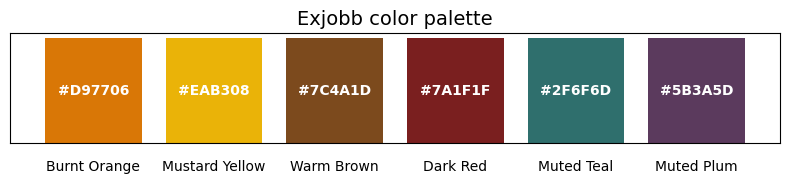

In [2]:
# Colors

colors = {
    "Burnt Orange": "#D97706",
    "Mustard Yellow": "#EAB308",
    "Warm Brown": "#7C4A1D",
    "Dark Red": "#7A1F1F",
    "Muted Teal": "#2F6F6D",
    "Muted Plum": "#5B3A5D"
}

plt.figure(figsize=(8, 2))

for i, (name, hex_code) in enumerate(colors.items()):
    plt.bar(i, 1, color=hex_code)
    plt.text(i, -0.15, name, ha='center', va='top', fontsize=10)
    plt.text(i, 0.5, hex_code, ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.xticks([])
plt.yticks([])
plt.title("Exjobb color palette", fontsize=14)
plt.tight_layout()
plt.show()

In [3]:
ARDS_COLORS = get_colors("ards")
COLOR = get_colors("palette")
COLORS_SEQUENTIAL_TEAL = get_colors("sequential_teal")
COLORS_SEQUENTIAL_ORANGE = get_colors("sequential_orange")


In [4]:
df_org = pd.read_csv('clean_dat.csv')
df_org.head()

/var/folders/rz/3cfhhdrd2bs65msqx2gtqcph0000gn/T/ipykernel_37567/146913330.py:1: DtypeWarning: Columns (0: SampleNotes, 1: AssayNotes) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv('clean_dat.csv')


,PlateId,PlateRunDate,ScannerID,PlatePosition,SlideId,Subarray,SampleId,SampleType,PercentDilution,SampleMatrix,...,age,female,icu_start.y,los_minutes,vent_time,survival_days,mort30d,mort90d,saps3_total,saps3_emr_swe
0,PLT36510,2024-12-17,SG17164580,A1,258740120244,1,2008749651,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PLT36510,2024-12-17,SG17164580,B1,258740120244,2,2008687169,Sample,20,EDTA Plasma,...,79.0,False,2016-06-13T16:26:00Z,3094.0,90.0,1596.0,False,False,86.0,69.5
2,PLT36510,2024-12-17,SG17164580,D1,258740120244,4,2011746806,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PLT36510,2024-12-17,SG17164580,E1,258740120244,5,2006647841,Sample,20,EDTA Plasma,...,45.0,False,2016-04-12T21:00:00Z,4080.0,3540.0,3.0,True,True,65.0,28.0
4,PLT36510,2024-12-17,SG17164580,F1,258740120244,6,2008931189,Sample,20,EDTA Plasma,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Originaldata
print("Start")
print(f"Antal patienter (rader): {df_org.shape[0]}")
print(f"Antal variabler (kolumner): {df_org.shape[1]}")
print()

# Behåll endast patienter med sepsis
mask_sepsis = df_org['Sepsis'] == True
df1 = df_org.loc[mask_sepsis].copy()

print("Efter sepsis-filter")
print(f"Antal patienter före: {df_org.shape[0]}")
print(f"Antal patienter efter: {df1.shape[0]}")
print(f"Borttagna (utan sepsis): {df_org.shape[0] - df1.shape[0]}")
print()

# Ta bort mild ARDS endast om ARDS = True
mask_mild_ards = (
    (df1['ards_severity'] == 'Mild') |
    (df1['ards_mild'] == True) |
    (df1['ards_notmild'] == False)
)

mask_remove = (df1['ards'] == True) & mask_mild_ards
data = df1.loc[~mask_remove].copy()

print("Efter ARDS-filter (ta bort mild ARDS om ARDS=True)")
print(f"Antal patienter före: {df1.shape[0]}")
print(f"Antal patienter efter: {data.shape[0]}")
print(f"Borttagna mild ARDS: {mask_remove.sum()}")
print()

print("Slutlig ARDS-status:")
print(data['ards'].value_counts(dropna=False))
print()

print("Slutlig ARDS-severity (ARDS=True):")
print(
    data.loc[data['ards'] == True, 'ards_severity']
    .value_counts(dropna=False)
)
print()

print("Slutlig kontroll av ARDS-kolumner:")
for col in ['ards_severity', 'ards_mild', 'ards_notmild']:
    print(f"\n{col}")
    print(data[col].value_counts(dropna=False))


Start
Antal patienter (rader): 1449
Antal variabler (kolumner): 10831

Efter sepsis-filter
Antal patienter före: 1449
Antal patienter efter: 418
Borttagna (utan sepsis): 1031

Efter ARDS-filter (ta bort mild ARDS om ARDS=True)
Antal patienter före: 418
Antal patienter efter: 409
Borttagna mild ARDS: 9

Slutlig ARDS-status:
ards
False    343
True      65
NaN        1
Name: count, dtype: int64

Slutlig ARDS-severity (ARDS=True):
ards_severity
Moderate    44
Severe      21
Name: count, dtype: int64

Slutlig kontroll av ARDS-kolumner:

ards_severity
ards_severity
NaN         344
Moderate     44
Severe       21
Name: count, dtype: int64

ards_mild
ards_mild
NaN      344
False     65
Name: count, dtype: int64

ards_notmild
ards_notmild
False    343
True      65
NaN        1
Name: count, dtype: int64


# Confounding factors

## MEN / WOMEN

In [6]:
nbr_men = data['female'].value_counts().get(False, 0)
nbr_women = data['female'].value_counts().get(True, 0)
print("Number of men: ", nbr_men)
print("Number of women: ",nbr_women)

Number of men:  252
Number of women:  157


### AGE

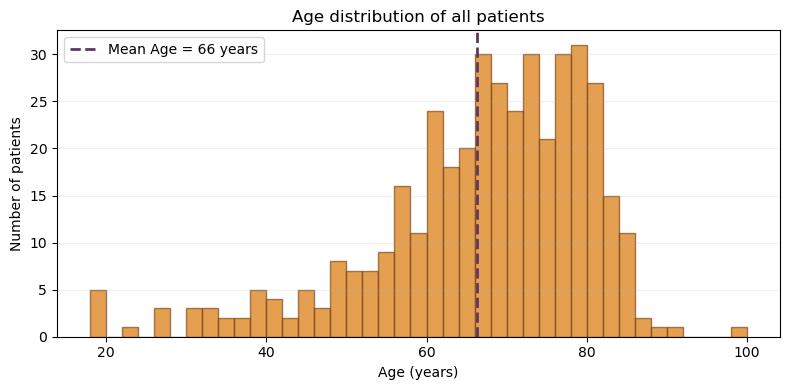

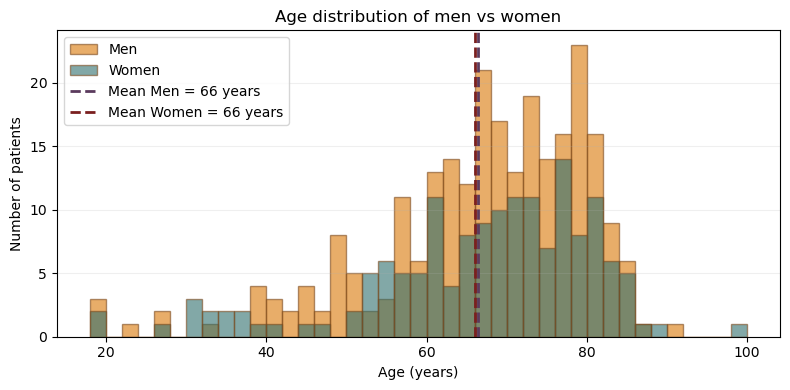

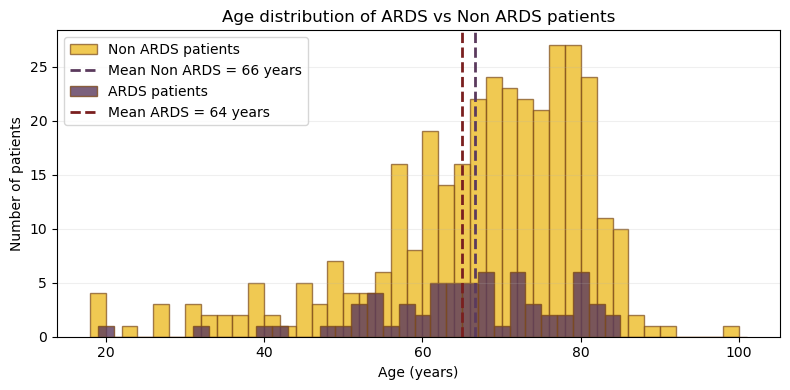

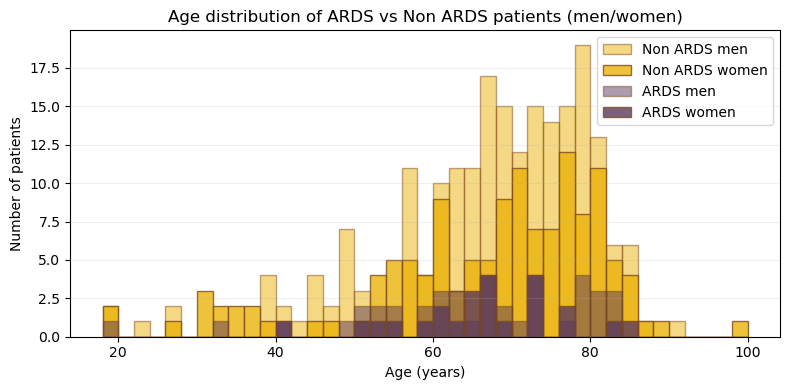

In [7]:
# Plot histogram of age distribution
######## All patients ##############
ages = data['age'].dropna()
plt.figure(figsize=(8, 4))
plt.hist(
    ages,
    bins=range(int(ages.min()), int(ages.max()) + 2, 2),
    color=COLOR['primary'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.7
)
plt.axvline(
    ages.mean(),
    linestyle='--',
    color=COLOR['accent'],        
    linewidth=2,
    label=f'Mean Age = {int(ages.mean())} years'
)
plt.legend()
plt.title('Age distribution of all patients', fontsize=12)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Number of patients', fontsize=10)
plt.grid(axis='y', alpha=0.2)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

######## All patients men/women ##############
ages_men = data[data['female'] == False]['age'].dropna()
ages_women = data[data['female'] == True]['age'].dropna()
bins = range(int(ages.min()), int(ages.max()) + 2, 2)
plt.figure(figsize=(8, 4))
plt.hist(
    ages_men,
    bins=bins,
    color=COLOR['primary'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.6,
    label = "Men"
)
plt.hist(
    ages_women,
    bins=bins,
    color=COLOR['secondary'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.6,
    label = "Women"
)
plt.axvline(
    ages_men.mean(),
    linestyle='--',
    color=COLOR['accent'],        
    linewidth=2,
    label=f'Mean Men = {int(ages_men.mean())} years'
)
plt.axvline(
    ages_women.mean(),
    linestyle='--',
    color=COLOR['danger'],        
    linewidth=2,
    label=f'Mean Women = {int(ages_women.mean())} years'
)
plt.legend()
plt.title('Age distribution of men vs women', fontsize=12)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Number of patients', fontsize=10)
plt.grid(axis='y', alpha=0.2)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()
    

######### ARDS vs non-ARDS ###########
ages_non_ards = data[data['ards'] == 0]['age'].dropna()
bins = range(int(ages.min()), int(ages.max()) + 2, 2)
plt.figure(figsize=(8, 4))
plt.hist(
    ages_non_ards,
    bins=bins,
    color=ARDS_COLORS['Not ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.7,
    label = "Non ARDS patients"
)
plt.axvline(
    ages_non_ards.mean(),
    linestyle='--',
    color=COLOR['accent'],        # Dark Red
    linewidth=2,
    label=f'Mean Non ARDS = {int(ages_non_ards.mean())} years' 
)
ages_ards = data[data['ards'] == 1]['age']
bins_ards = range(int(ages_ards.min()), int(ages.max()) + 2, 2)
plt.hist(
    ages_ards,
    bins=bins_ards,
    color=ARDS_COLORS['ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.8,
    label='ARDS patients'
)
plt.axvline(
    ages_ards.mean(),
    linestyle='--',
    color=COLOR['danger'],        
    linewidth=2,
    label=f'Mean ARDS = {int(ages_ards.mean())} years' 
)
plt.legend()
plt.title('Age distribution of ARDS vs Non ARDS patients', fontsize=12)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Number of patients', fontsize=10)
plt.grid(axis='y', alpha=0.2)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

########### ARDS vs Non ARDS men / women ##########
ages_non_ards_men = data[(data['ards'] == 0) & (data['female'] == False)]['age'].dropna()
ages_non_ards_women = data[(data['ards'] == 0) & (data['female'] == True)]['age'].dropna()
ages_ards_men = data[(data['ards'] == 1) & (data['female'] == False)]['age'].dropna()
ages_ards_women = data[(data['ards'] == 1) & (data['female'] == True)]['age'].dropna()
bins = range(int(ages.min()), int(ages.max()) + 2, 2)
plt.figure(figsize=(8, 4))
plt.hist(
    ages_non_ards_men,
    bins=bins,
    color=ARDS_COLORS['Not ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.5,
    label = "Non ARDS men"
)
plt.hist(
    ages_non_ards_women,
    bins=bins,
    color=ARDS_COLORS['Not ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.8,
    label = "Non ARDS women"
)
plt.hist(
    ages_ards_men,
    bins=bins,
    color=ARDS_COLORS['ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.5,
    label = "ARDS men"
)
plt.hist(
    ages_ards_women,
    bins=bins,
    color=ARDS_COLORS['ARDS'],        
    edgecolor=COLOR['neutral'],    
    alpha=0.8,
    label = "ARDS women"
)
plt.legend()
plt.title('Age distribution of ARDS vs Non ARDS patients (men/women)', fontsize=12)
plt.xlabel('Age (years)', fontsize=10)
plt.ylabel('Number of patients', fontsize=10)
plt.grid(axis='y', alpha=0.2)
plt.grid(axis='x', visible=False)
plt.tight_layout()
plt.show()

## IVA Avdelning

In [8]:
# Number of patients per IVAavd and ARDS status

counts_iva = data['IVAavd'].value_counts()
counts_ards = (
    data
    .groupby(['IVAavd', 'ards'])
    .size()
    .unstack(fill_value=0)
)
proportions_ards = counts_ards.div(counts_ards.sum(axis=1), axis=0)
summary = counts_ards.copy()
summary['Total'] = summary.sum(axis=1)
summary['ARDS_prop'] = summary[1] / summary['Total']
summary['NonARDS_prop'] = summary[0] / summary['Total']

print(summary)

ards         False  True  Total  ARDS_prop  NonARDS_prop
IVAavd                                                  
Helsingborg    124    10    134   0.074627      0.925373
Lund            90    26    116   0.224138      0.775862
Malmo          129    29    158   0.183544      0.816456


# Proteins

In [9]:
# Protein data

protein_data = data.loc[:, data.columns.str.startswith("seq")]
print("Patiens, nbr of proteins: ", protein_data.shape)
protein_data.head()

Patiens, nbr of proteins:  (409, 10776)


,seq.10000.28,seq.10001.7,seq.10003.15,seq.10006.25,seq.10008.43,seq.10010.10,seq.10011.65,seq.10012.5,seq.10014.31,seq.10015.119,...,seq.9984.12,seq.9986.14,seq.9987.30,seq.9989.12,seq.9991.112,seq.9993.11,seq.9994.217,seq.9995.6,seq.9997.12,seq.9999.1
1,2.598134,2.538825,1.990339,2.666143,2.520090,2.426999,3.099266,3.022923,2.902166,2.893373,...,2.667453,3.556206,2.376029,2.723948,2.476976,2.950267,3.104521,3.439743,4.385402,3.112001
3,2.588496,2.490099,2.073718,2.922674,2.476976,2.384353,3.125774,2.889077,2.884569,2.751125,...,2.624282,3.247163,2.339054,2.744919,2.629919,2.874482,3.162923,3.325064,4.197049,3.213039
7,2.616790,2.575880,2.357554,2.773348,2.545060,2.383277,3.105408,2.902112,3.269349,2.863917,...,2.612572,3.401676,2.318689,2.752663,2.443889,2.924899,3.098332,4.029014,4.588454,3.314668
12,2.563837,2.540329,1.965202,2.746945,2.584331,2.457276,3.201015,3.083108,2.881271,2.785686,...,2.660391,3.757662,2.563125,2.661623,2.507586,2.863025,3.129529,3.643314,4.538662,3.247335
13,2.636287,2.505150,2.041787,2.672652,2.533772,2.424555,3.156428,2.974327,2.904337,2.743118,...,2.646208,3.309247,2.367729,3.290613,2.659536,2.948657,3.170467,3.560062,4.227604,3.078094


Patiens, nbr of proteins Non ARDS:  (343, 10776)
Patiens, nbr of proteins ARDS:  (65, 10776)
Max protein value all:  5.789651208793409
Max protein value non ards:  5.789651208793409
Max protein value ards:  5.69272648055909
Min protein value:  0.255272505103306
count    4.407384e+06
mean     3.041884e+00
std      5.934873e-01
min      2.552725e-01
25%      2.626546e+00
50%      2.934852e+00
75%      3.347310e+00
90%      3.881316e+00
99%      4.782616e+00
max      5.789651e+00
dtype: float64


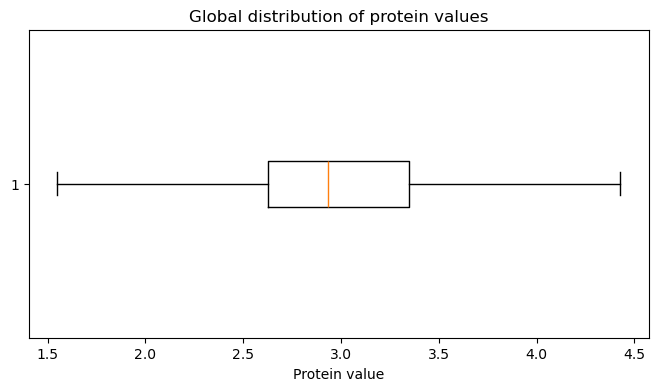

In [10]:
# Protein information

protein_ards = protein_data[data['ards'] == 1]
protein_non_ards = protein_data[data['ards'] == 0]
print("Patiens, nbr of proteins Non ARDS: ", protein_non_ards.shape)
print("Patiens, nbr of proteins ARDS: ", protein_ards.shape)

print("Max protein value all: ", protein_data.max().max())
print("Max protein value non ards: ", protein_non_ards.max().max())
print("Max protein value ards: ", protein_ards.max().max())
print("Min protein value: ", protein_data.min().min())

values = protein_data.values.flatten()
print(pd.Series(values).describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.99]))

plt.figure(figsize=(8,4))
plt.boxplot(values, vert=False, showfliers=False)
plt.xlabel("Protein value")
plt.title("Global distribution of protein values")
plt.show()

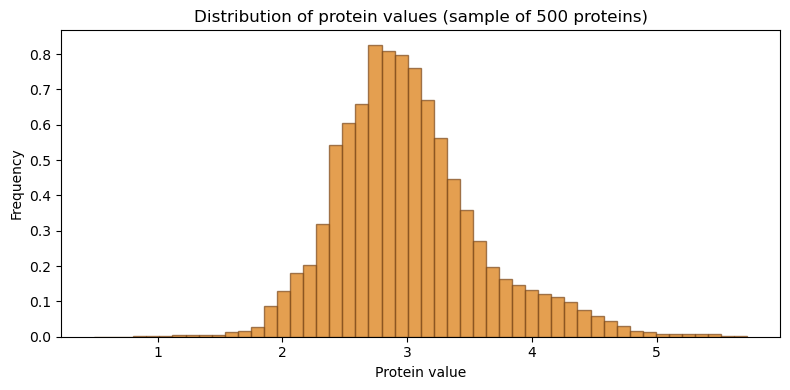

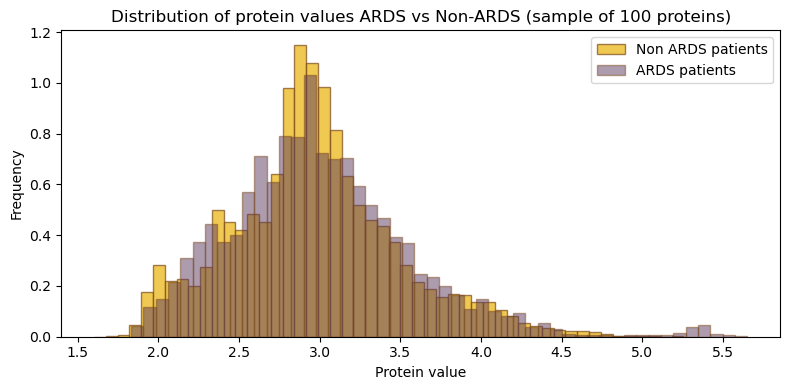

In [11]:
# Plot distribution of protein values (sample of 500 proteins)

values = protein_data.sample(500, axis=1).values.flatten()

values_ards = protein_data[data['ards'] == 1].sample(100, axis=1).values.flatten()
values_non_ards = protein_data[data['ards'] == 0].sample(100, axis=1).values.flatten()

plt.figure(figsize=(8,4))
plt.hist(
    values,
    bins=50,
    color=COLOR['primary'],
    edgecolor=COLOR['neutral'],
    alpha=0.7,
    density=True
)
plt.title("Distribution of protein values (sample of 500 proteins)")
plt.xlabel("Protein value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(
    values_non_ards,
    bins=50,
    color=ARDS_COLORS['Not ARDS'],
    edgecolor=COLOR['neutral'],
    alpha=0.7,
    label='Non ARDS patients',
    density=True
)
plt.hist(
    values_ards,
    bins=50,
    color=ARDS_COLORS['ARDS'],
    edgecolor=COLOR['neutral'],
    alpha=0.5,
    label='ARDS patients',
    density=True
)
plt.title("Distribution of protein values ARDS vs Non-ARDS (sample of 100 proteins)")
plt.xlabel("Protein value")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

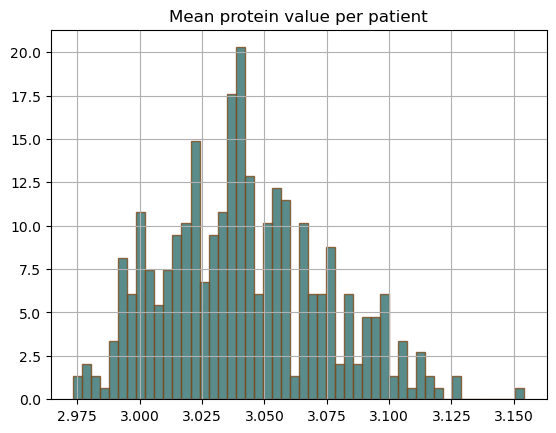

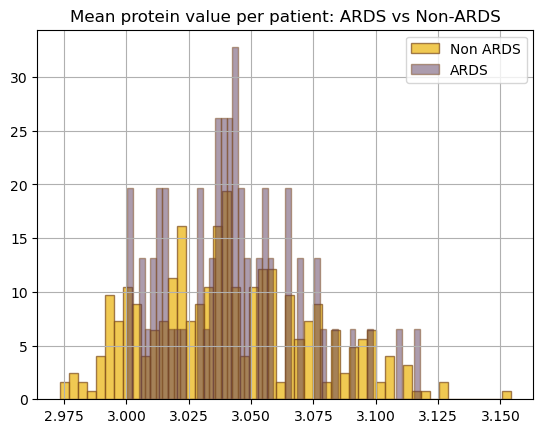

In [16]:
# Mean value per patient

protein_data.mean(axis=1).hist(bins=50, color=COLOR['secondary'], edgecolor=COLOR['neutral'], density=True, alpha=0.8)
plt.title("Mean protein value per patient")
plt.show()
protein_non_ards.mean(axis=1).hist(bins=50, color=ARDS_COLORS['Not ARDS'], edgecolor=COLOR['neutral'], density=True, alpha=0.7, label='Non ARDS')
protein_ards.mean(axis=1).hist(bins=50, color=ARDS_COLORS['ARDS'], edgecolor=COLOR['neutral'], density=True, alpha=0.5, label='ARDS')
plt.title("Mean protein value per patient: ARDS vs Non-ARDS")
plt.legend()
plt.show()

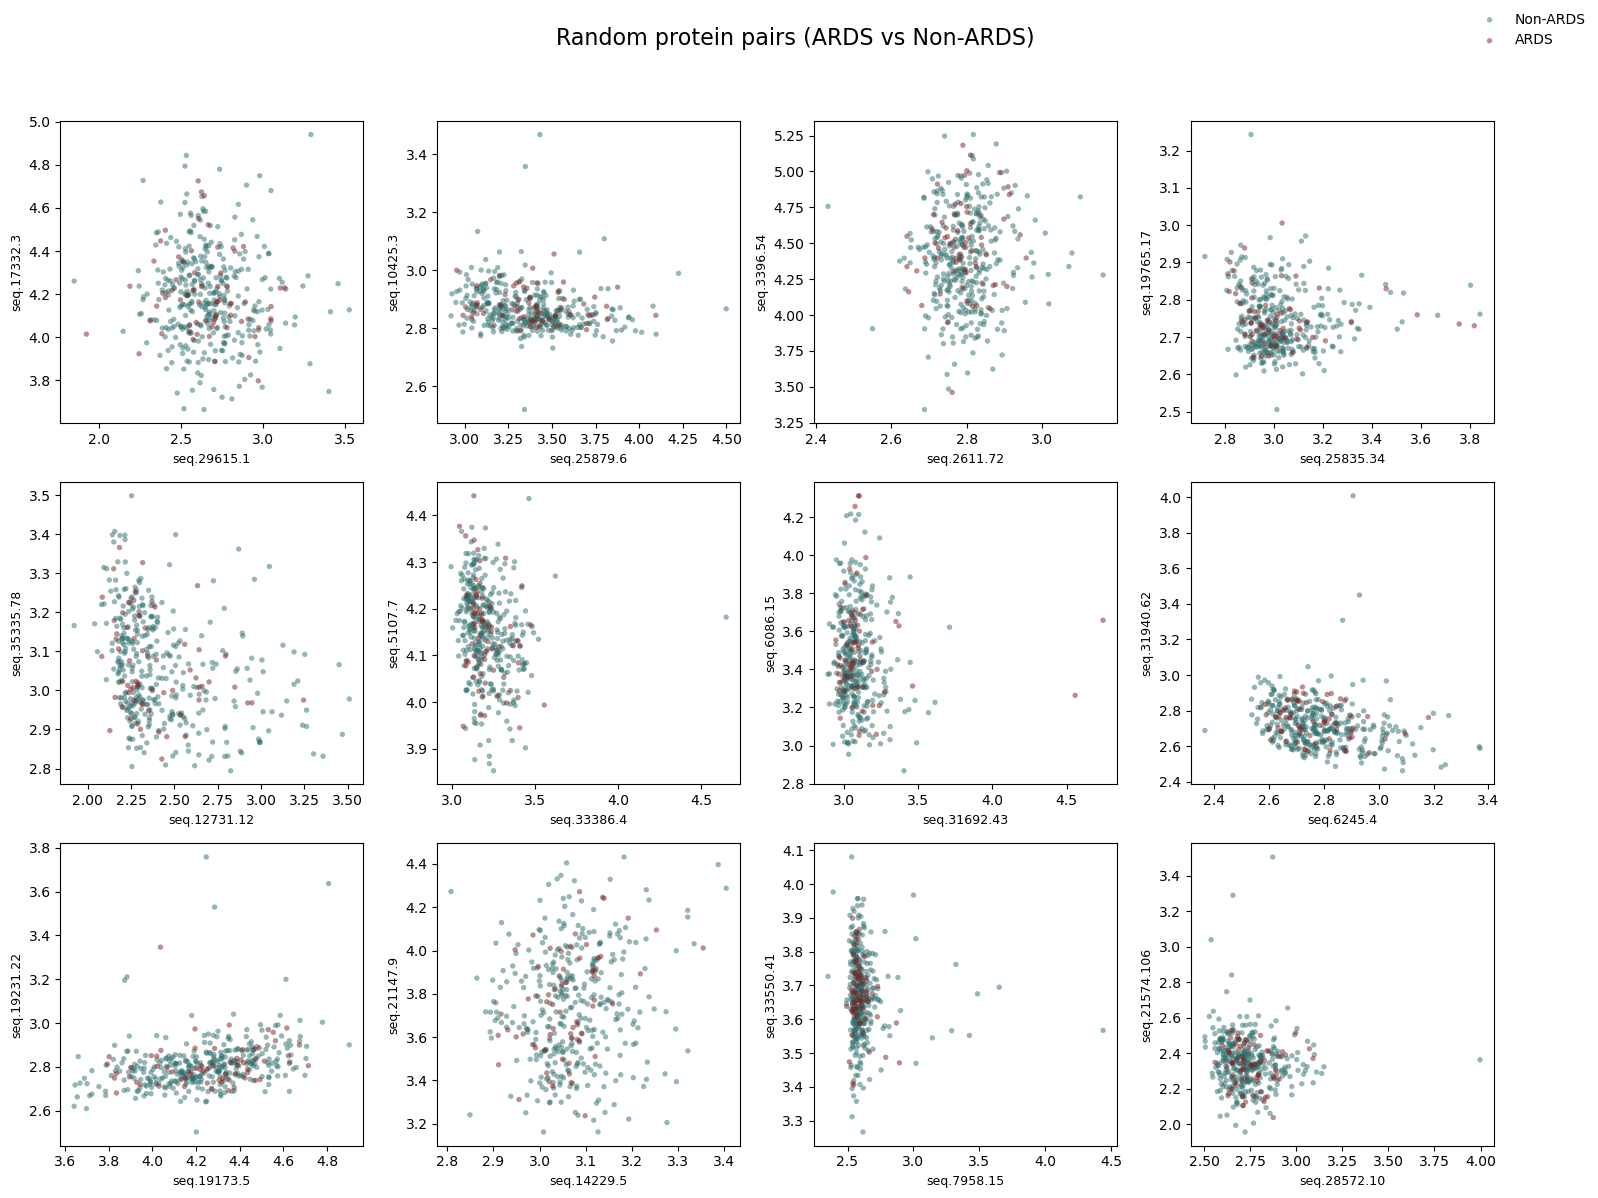

In [13]:
pairs = [np.random.choice(protein_data.columns, 2, replace=False) for _ in range(12)]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Masker för grupper
mask_ards = data['ards'] == True
mask_non_ards = data['ards'] == False

for ax, (p1, p2) in zip(axes.flat, pairs):

    # Non-ARDS
    ax.scatter(
        protein_data.loc[mask_non_ards, p1],
        protein_data.loc[mask_non_ards, p2],
        s=15,
        alpha=0.5,
        color=COLOR['secondary'],
        edgecolors='none',
        label='Non-ARDS'
    )

    # ARDS
    ax.scatter(
        protein_data.loc[mask_ards, p1],
        protein_data.loc[mask_ards, p2],
        s=15,
        alpha=0.5,
        color=COLOR['danger'],
        edgecolors='none',
        label='ARDS'
    )

    ax.set_xlabel(p1, fontsize=9)
    ax.set_ylabel(p2, fontsize=9)

# Gemensam legend (en gång räcker)
handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', frameon=False)

plt.suptitle("Random protein pairs (ARDS vs Non-ARDS)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.95, 0.95])
plt.show()


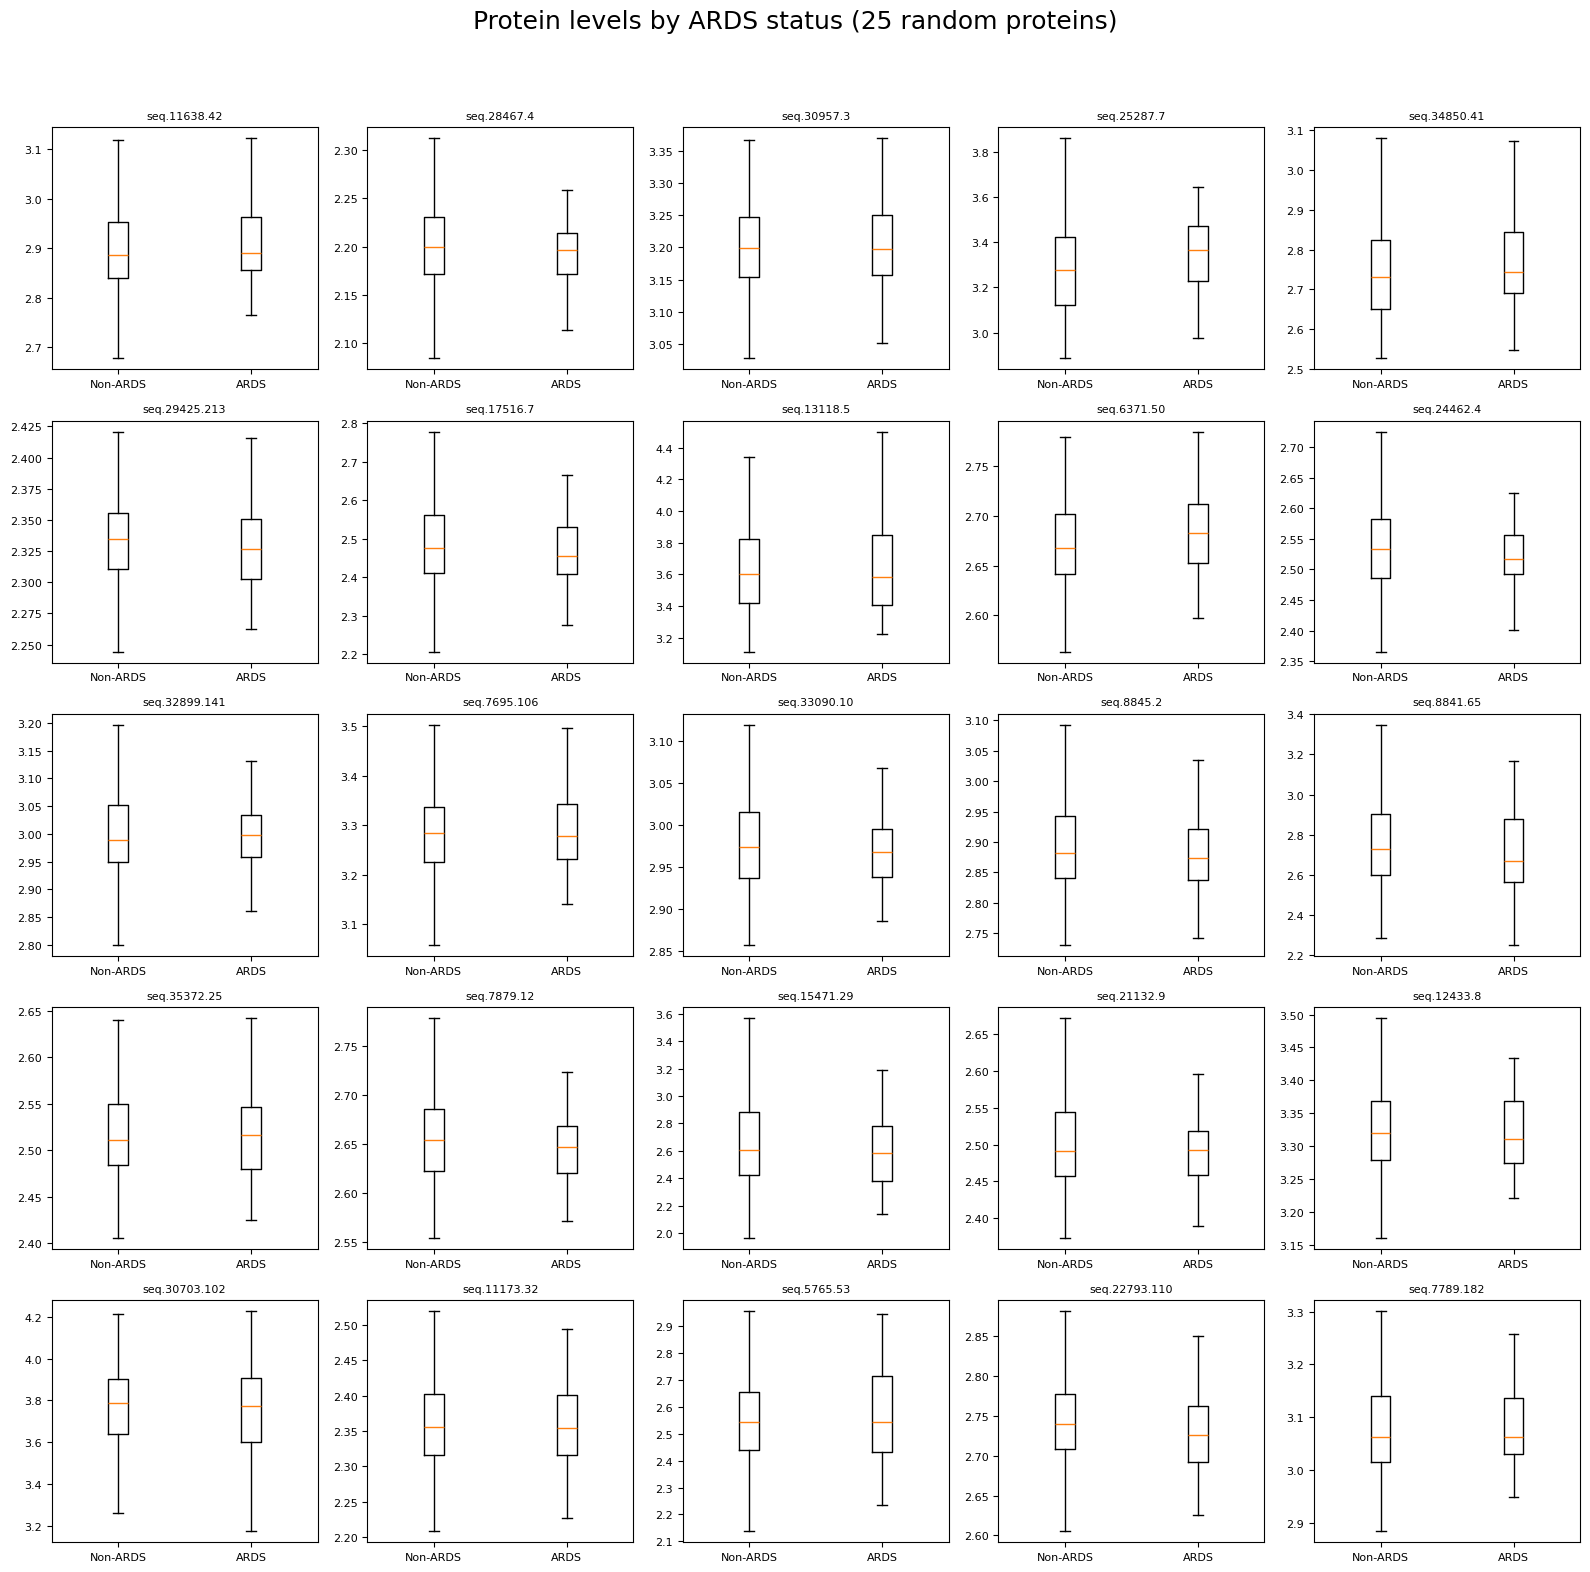

In [14]:
# Slumpa 25 proteiner och titta på boxplots för ARDS vs Non-ARDS

proteins = np.random.choice(protein_data.columns, 25, replace=False)

fig, axes = plt.subplots(5, 5, figsize=(16, 16))
axes = axes.flatten()

for ax, p in zip(axes, proteins):

    non_ards = protein_data.loc[data['ards'] == False, p].dropna()
    ards = protein_data.loc[data['ards'] == True, p].dropna()

    ax.boxplot(
        [non_ards, ards],
        tick_labels=['Non-ARDS', 'ARDS'],
        showfliers=False
    )

    ax.set_title(p, fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

plt.suptitle("Protein levels by ARDS status (25 random proteins)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()